In [1]:

import _init_
from constants import *
from set_path import *
from config import *
from functions import *
import seaborn as sns


In [2]:
plt.rcParams['font.size']=24
plt.rcParams['axes.linewidth']=0.1
plt.rcParams['xtick.major.size']=6
plt.rcParams['xtick.minor.size']=1
plt.rcParams['xtick.major.width']=2
plt.rcParams['xtick.minor.width']=2.
plt.rcParams['xtick.direction']='in'
plt.rcParams['ytick.major.size']=12
plt.rcParams['ytick.minor.size']=6
plt.rcParams['ytick.major.width']=2
plt.rcParams['ytick.minor.width']=2
plt.rcParams['ytick.direction']='in'

In [27]:
grackledata = h5py.File(grackle)
array = grackledata['CoolingRates/Primordial/MMW'][()]
#density(1.e-6, 1.e4), redshift(0,15), temperature(10., 1.e9)
table = array[:,0,:]
table_nH   = np.logspace(-10, 4, array.shape[0])
table_temp = np.logspace(1,  9, array.shape[2])
gamma = 5./3.


In [4]:
i=0
bins = 100
egas_arr = np.logspace(-24., -5., bins)
nH_arr   = np.logspace(-6.0, 4.0, int(bins))
T = np.zeros((egas_arr.shape[0],nH_arr.shape[0]))


for egas in egas_arr:
    j=0
    for nH in nH_arr:
        C = (gamma - 1.) * egas / (boltzmann_constant_cgs*nH)
        minT = C*np.amin(table)
        maxT = C*np.amax(table)
        def func(T):
            mu = interpolate.interp2d(table_temp, table_nH, table,\
                              kind='linear', copy=True, bounds_error=False, fill_value=None)
            return C*mu(T,nH)[0] - T

        T[i,j] = scipy.optimize.toms748(func, minT, maxT)
        j+=1
    i+=1

In [72]:
home = '/g/data/jh2/av5889/quokka_myrepo/quokka/sims/SummitData/GasGravity/Production2pc/'

data_folder = ['R4/slice-3000000.h5', 'R8/slice-3910000.h5', 'R16/4pc/Redo/slice-850000.h5']



# Slice for 4 Sigma

/jobfs/126581624.gadi-pbs/ipykernel_3049864/4183515058.py:53: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plot = ax[0].pcolormesh(xrange/kpc,zrange/kpc, np.transpose(np.log10(rho_gas/mp)),\
/jobfs/126581624.gadi-pbs/ipykernel_3049864/4183515058.py:62: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plot = ax[1].pcolormesh(xrange/kpc,zrange/kpc, np.transpose((temp)),\
/jobfs/126581624.gadi-pbs/ipykernel_3049864/4183515058.py:70: MatplotlibDeprecationWarning: 

Created file-- /g/data/jh2/av5889/quokka_myrepo/Analysis/figures/Paper/sigma4_slice_full.jpeg


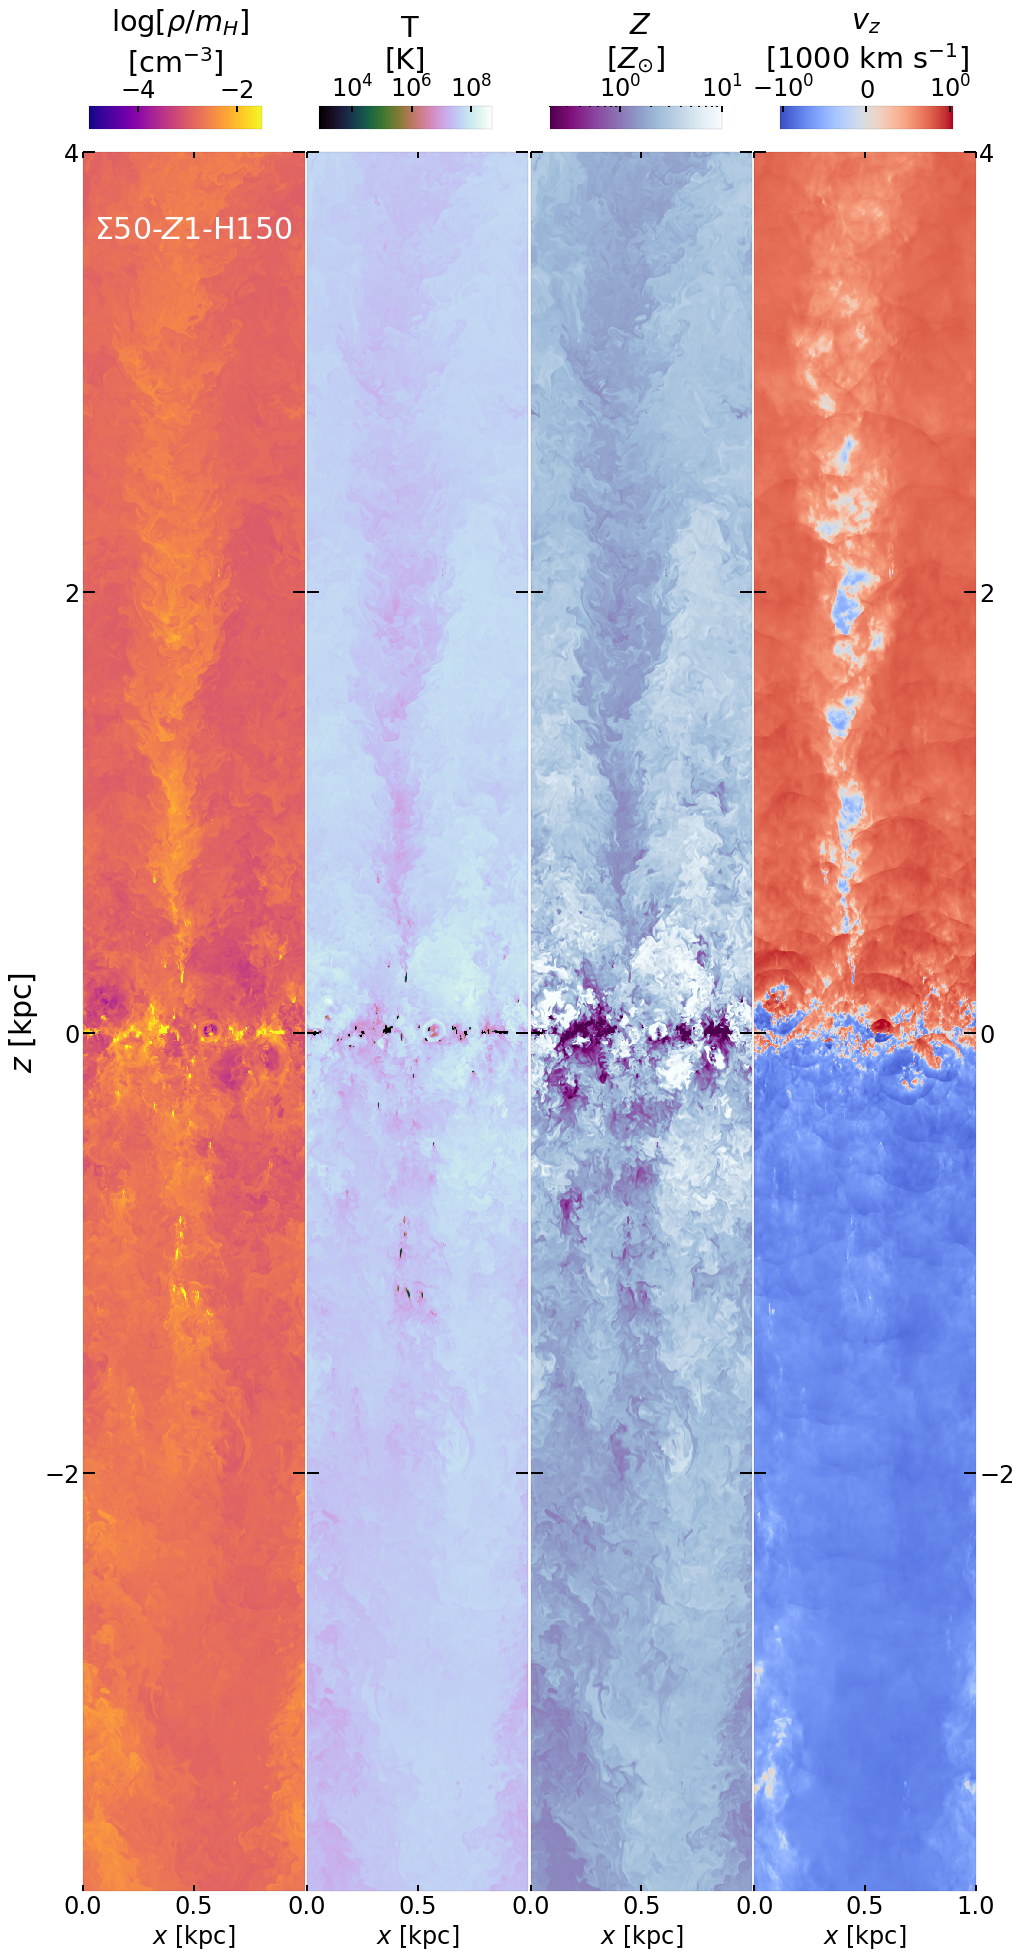

In [26]:
fig, ax = plt.subplots(1, 4, gridspec_kw = {'wspace':0.01, 'hspace':0.0},figsize=(16, 32))
i=0

cbarx = 0.13
cbheight = 0.01
cbary = 0.89
cblen = 0.15
dx1 = 0.2
cbtitlex = 0.1
cbtitley = 16.5

kk=0


folder = data_folder[0]

data_path = os.path.join(home, folder)
hf = h5py.File(data_path ,'r')

eint = np.array(hf.get("IntEnergy"))
timestep = np.array(hf.get("Timestep")) 
zrange = np.array(hf.get("Zrange"))
xrange = np.array(hf.get("Xrange"))
rho_gas = np.array(hf.get("Rho")) 
rhoZ = np.array(hf.get("RhoZ")) 
vz = np.array(hf.get("Vz")) 
abund = (rhoZ/rho_gas)*Msun/1.e3


cloudy_H_mass_fraction = 1. / (1. + 0.1 * 3.971)
rho0 = rho_gas*cloudy_H_mass_fraction/hydrogen_mass_cgs

logrho_arr = np.log10(nH_arr[:-1])
logrho     = np.log10(rho0)
delta_rho  = logrho_arr[1] - logrho_arr[0]
idxrho     = (np.floor((logrho - np.amin(logrho_arr))/delta_rho)).astype('int')

logEgas_arr = np.log10(egas_arr[:-1])
logEgas     = np.log10(eint)
delta_egas  = logEgas_arr[1] - logEgas_arr[0]
idxegas     = (np.floor((logEgas-np.amin(logEgas_arr))/delta_egas)).astype('int')


wgt_rho  = (logrho - (np.amin(logrho_arr) + delta_rho*idxrho))/delta_rho
wgt_egas = (logEgas - (np.amin(logEgas_arr) + delta_egas*idxegas))/delta_egas

temp = (1.-wgt_rho)*(1.-wgt_egas)* T[tuple(idxegas)  , tuple(idxrho)]   +\
        wgt_rho *    wgt_egas * T[tuple(idxegas+1), tuple(idxrho+1)] +\
    (1. -wgt_rho)*    wgt_egas * T[tuple(idxegas+1), tuple(idxrho)]   +\
        wgt_rho *(1.-wgt_egas)* T[tuple(idxegas)  , tuple(idxrho+1)]  


plot = ax[0].pcolormesh(xrange/kpc,zrange/kpc, np.transpose(np.log10(rho_gas/mp)),\
                vmin=-5., vmax=-1.5,
                cmap=sns.color_palette(palette='plasma', as_cmap=True))
cax = fig.add_axes([cbarx, cbary, cblen, cbheight])
fig.colorbar(plot, cax=cax, orientation='horizontal', ticks=(-6, -4, -2.))
cax.xaxis.set_ticks_position('top')
cax.set_title(r" $\mathrm{log} [\rho/m_H]$" + "\n" + "[cm$^{-3}$]")
# ax[0].text(0.4, 0.9, '%.2f'%(timestep) + ' Myr', transform = ax[0].transAxes, color='black')

plot = ax[1].pcolormesh(xrange/kpc,zrange/kpc, np.transpose((temp)),\
                norm=mcolors.LogNorm(vmin=8.e2, vmax=5.e8),
                cmap=sns.color_palette(palette="cubehelix", as_cmap=True))
cax = fig.add_axes([cbarx + dx1, cbary, cblen, cbheight])
fig.colorbar(plot, cax=cax, orientation='horizontal', ticks=(1.e4, 1.e6, 1.e8))
cax.xaxis.set_ticks_position('top')
cax.set_title(r" T" + "\n" + "[K]")

plot = ax[2].pcolormesh(xrange/kpc,zrange/kpc, np.transpose(abund)/8.6e-3,\
                norm=mcolors.LogNorm(vmin=2.e-1, vmax=10.2),
                cmap=sns.color_palette("BuPu_r", as_cmap=True))
cax = fig.add_axes([cbarx + 2.*dx1, cbary, cblen, cbheight])
fig.colorbar(plot, cax=cax, orientation='horizontal', ticks=(1.e-1, 1., 1.e1))
cax.xaxis.set_ticks_position('top')
cax.set_title(r" $Z$ " + "\n" + r"$[Z_{\odot}]$")

plot = ax[3].pcolormesh(xrange/kpc,zrange/kpc, np.transpose(vz)/kmps/1.e3,\
                norm=mcolors.SymLogNorm(vmin=-1.2, vmax=1.2, linthresh=0.05),
                cmap='coolwarm')
cax = fig.add_axes([cbarx + 3.*dx1, cbary, cblen, cbheight])
fig.colorbar(plot, cax=cax, orientation='horizontal', ticks=(-1., 0.0, 1.))
cax.xaxis.set_ticks_position('top')
cax.set_title(r"$v_z$" + "\n" + r"$[1000$ km s$^{-1}]$")


ax[0].tick_params(axis='y', labelleft=True, labelright=False, right=True, left=True)
ax[1].tick_params(axis='y', labelleft=False, labelright=False, right=True, left=True)
ax[2].tick_params(axis='y', labelleft=False, labelright=False, right=True, left=True)
ax[ -1].tick_params(axis='y', labelleft=False, labelright=True, right=True, left=True)

ax[0].tick_params(axis='x', labelbottom=True, top=True, bottom=True)
ax[1].tick_params(axis='x', labelbottom=True, top=True, bottom=True)
ax[2].tick_params(axis='x', labelbottom=True, top=True, bottom=True)
ax[3].tick_params(axis='x', labelbottom=True, top=True, bottom=True) 

ax[0].text(0.05, 0.95, r'$\Sigma50$-$Z1$-H$150$', transform=ax[0].transAxes, color='white', fontsize=30)

plt.setp(ax, 'ylim', (-3.9,4.))
plt.setp(ax, 'xlim', (0.0,1.0))

plt.setp(ax, 'yticks', (-2., 0.0, 2.0, 4.0))
ax[-1].set_xticks((0.0, 0.5, 1.0))

ax[0].set_ylabel(r'$z$ [kpc]', fontsize=30)
kk+=1
plt.setp(ax, 'xlabel', r'$x$ [kpc]')
plt.setp(ax, 'xticks', (0.0,0.5))
plt.setp(ax[-1], 'xticks', (0.0,0.5, 1.0))

filename = fig_path + '/Paper/sigma4_slice_full.jpeg'
plt.savefig(filename, bbox_inches='tight', dpi=160)
print('Created file--', filename)

# Fiducial Slice

/jobfs/126640808.gadi-pbs/ipykernel_2432450/2642051943.py:54: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plot = ax[0].pcolormesh(xrange/kpc,zrange/kpc, np.transpose(np.log10(rho_gas/mp)),\
/jobfs/126640808.gadi-pbs/ipykernel_2432450/2642051943.py:63: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plot = ax[1].pcolormesh(xrange/kpc,zrange/kpc, np.transpose((temp)),\
/jobfs/126640808.gadi-pbs/ipykernel_2432450/2642051943.py:71: MatplotlibDeprecationWarning: 

Created file-- /g/data/jh2/av5889/quokka_myrepo/Analysis/figures/Paper/sigmafid_slice_full.jpeg


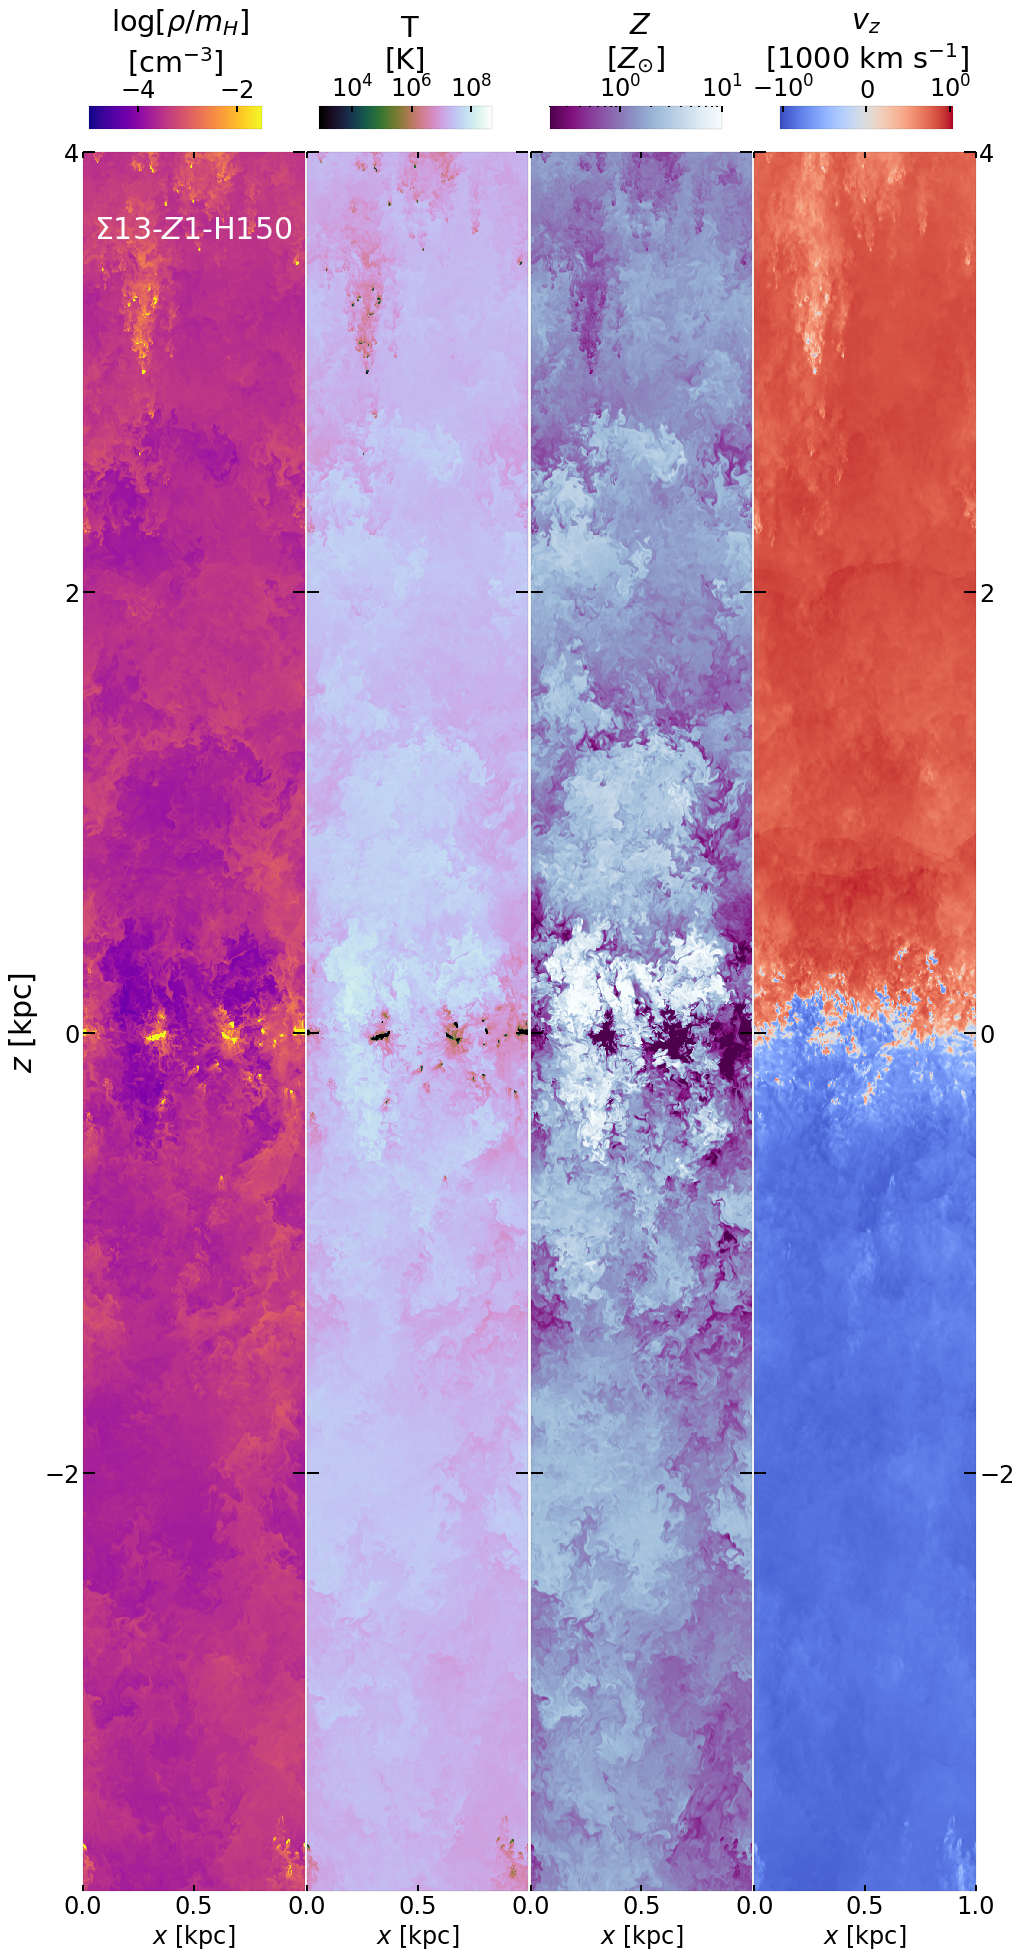

In [73]:
fig, ax = plt.subplots(1, 4, gridspec_kw = {'wspace':0.01, 'hspace':0.0},figsize=(16, 32))
i=0

cbarx = 0.13
cbheight = 0.01
cbary = 0.89
cblen = 0.15
dx1 = 0.2
cbtitlex = 0.1
cbtitley = 16.5

kk=0


folder = data_folder[1]

data_path = os.path.join(home, folder)
hf = h5py.File(data_path ,'r')

eint = np.array(hf.get("IntEnergy"))
timestep = np.array(hf.get("Timestep")) 
zrange = np.array(hf.get("Zrange"))
xrange = np.array(hf.get("Xrange"))
rho_gas = np.array(hf.get("Rho")) 
rhoZ = np.array(hf.get("RhoZ")) 
vz = np.array(hf.get("Vz")) 
abund = (rhoZ/rho_gas)*Msun/1.e3



cloudy_H_mass_fraction = 1. / (1. + 0.1 * 3.971)
rho0 = rho_gas*cloudy_H_mass_fraction/hydrogen_mass_cgs

logrho_arr = np.log10(nH_arr[:-1])
logrho     = np.log10(rho0)
delta_rho  = logrho_arr[1] - logrho_arr[0]
idxrho     = (np.floor((logrho - np.amin(logrho_arr))/delta_rho)).astype('int')

logEgas_arr = np.log10(egas_arr[:-1])
logEgas     = np.log10(eint)
delta_egas  = logEgas_arr[1] - logEgas_arr[0]
idxegas     = (np.floor((logEgas-np.amin(logEgas_arr))/delta_egas)).astype('int')


wgt_rho  = (logrho - (np.amin(logrho_arr) + delta_rho*idxrho))/delta_rho
wgt_egas = (logEgas - (np.amin(logEgas_arr) + delta_egas*idxegas))/delta_egas

temp = (1.-wgt_rho)*(1.-wgt_egas)* T[tuple(idxegas)  , tuple(idxrho)]   +\
        wgt_rho *    wgt_egas * T[tuple(idxegas+1), tuple(idxrho+1)] +\
    (1. -wgt_rho)*    wgt_egas * T[tuple(idxegas+1), tuple(idxrho)]   +\
        wgt_rho *(1.-wgt_egas)* T[tuple(idxegas)  , tuple(idxrho+1)]  


plot = ax[0].pcolormesh(xrange/kpc,zrange/kpc, np.transpose(np.log10(rho_gas/mp)),\
                vmin=-5., vmax=-1.5,
                cmap=sns.color_palette(palette='plasma', as_cmap=True))
cax = fig.add_axes([cbarx, cbary, cblen, cbheight])
fig.colorbar(plot, cax=cax, orientation='horizontal', ticks=(-6, -4, -2.))
cax.xaxis.set_ticks_position('top')
cax.set_title(r" $\mathrm{log} [\rho/m_H]$" + "\n" + "[cm$^{-3}$]")
# ax[0].text(0.4, 0.9, '%.2f'%(timestep) + ' Myr', transform = ax[0].transAxes, color='black')

plot = ax[1].pcolormesh(xrange/kpc,zrange/kpc, np.transpose((temp)),\
                norm=mcolors.LogNorm(vmin=8.e2, vmax=5.e8),
                cmap=sns.color_palette(palette="cubehelix", as_cmap=True))
cax = fig.add_axes([cbarx + dx1, cbary, cblen, cbheight])
fig.colorbar(plot, cax=cax, orientation='horizontal', ticks=(1.e4, 1.e6, 1.e8))
cax.xaxis.set_ticks_position('top')
cax.set_title(r" T" + "\n" + "[K]")

plot = ax[2].pcolormesh(xrange/kpc,zrange/kpc, np.transpose(abund)/8.6e-3,\
                norm=mcolors.LogNorm(vmin=2.e-1, vmax=10.2),
                cmap=sns.color_palette("BuPu_r", as_cmap=True))
cax = fig.add_axes([cbarx + 2.*dx1, cbary, cblen, cbheight])
fig.colorbar(plot, cax=cax, orientation='horizontal', ticks=(1.e-1, 1., 1.e1))
cax.xaxis.set_ticks_position('top')
cax.set_title(r" $Z$ " + "\n" + r"$[Z_{\odot}]$")

plot = ax[3].pcolormesh(xrange/kpc,zrange/kpc, np.transpose(vz)/kmps/1.e3,\
                norm=mcolors.SymLogNorm(vmin=-1.2, vmax=1.2, linthresh=0.05),
                cmap='coolwarm')
cax = fig.add_axes([cbarx + 3.*dx1, cbary, cblen, cbheight])
fig.colorbar(plot, cax=cax, orientation='horizontal', ticks=(-1., 0.0, 1.))
cax.xaxis.set_ticks_position('top')
cax.set_title(r"$v_z$" + "\n" + r"$[1000$ km s$^{-1}]$")


ax[0].tick_params(axis='y', labelleft=True, labelright=False, right=True, left=True)
ax[1].tick_params(axis='y', labelleft=False, labelright=False, right=True, left=True)
ax[2].tick_params(axis='y', labelleft=False, labelright=False, right=True, left=True)
ax[ -1].tick_params(axis='y', labelleft=False, labelright=True, right=True, left=True)

ax[0].tick_params(axis='x', labelbottom=True, top=True, bottom=True)
ax[1].tick_params(axis='x', labelbottom=True, top=True, bottom=True)
ax[2].tick_params(axis='x', labelbottom=True, top=True, bottom=True)
ax[3].tick_params(axis='x', labelbottom=True, top=True, bottom=True) 

ax[0].text(0.05, 0.95, r'$\Sigma13$-$Z1$-H$150$', transform=ax[0].transAxes, color='white', fontsize=30)

plt.setp(ax, 'ylim', (-3.9,4.))
plt.setp(ax, 'xlim', (0.0,1.0))

plt.setp(ax, 'yticks', (-2., 0.0, 2.0, 4.0))
ax[-1].set_xticks((0.0, 0.5, 1.0))

ax[0].set_ylabel(r'$z$ [kpc]', fontsize=30)
kk+=1
plt.setp(ax, 'xlabel', r'$x$ [kpc]')
plt.setp(ax, 'xticks', (0.0,0.5))
plt.setp(ax[-1], 'xticks', (0.0,0.5, 1.0))

filename = fig_path + '/Paper/sigmafid_slice_full.jpeg'
# plt.savefig(filename, bbox_inches='tight', dpi=160)
print('Created file--', filename)
entropy_volR8 = rho_gas * np.log(rho_gas**(1.-gamma)*temp)

# Side quest into Entropy

In [142]:
bins = 70
rho_arr = np.logspace(-3., 2., bins)
temp_arr = np.logspace(1.5, 8., bins+1)
ent_arr = np.zeros((rho_arr.shape[0], temp_arr.shape[0]))
for i in range(bins):
    for j in range(bins+1):
        entropy = rho_arr[i] * np.log(rho_arr[i]**(1.-gamma)*temp_arr[j])
        ent_arr[i,j] = entropy
        
np.amin(ent_arr), np.amax(ent_arr)



(0.008059047825479162, 1535.0567286626972)

/jobfs/126640808.gadi-pbs/ipykernel_2432450/1172966012.py:5: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plot = ax.pcolormesh(rho_arr, temp_arr, np.transpose(ent_arr),\


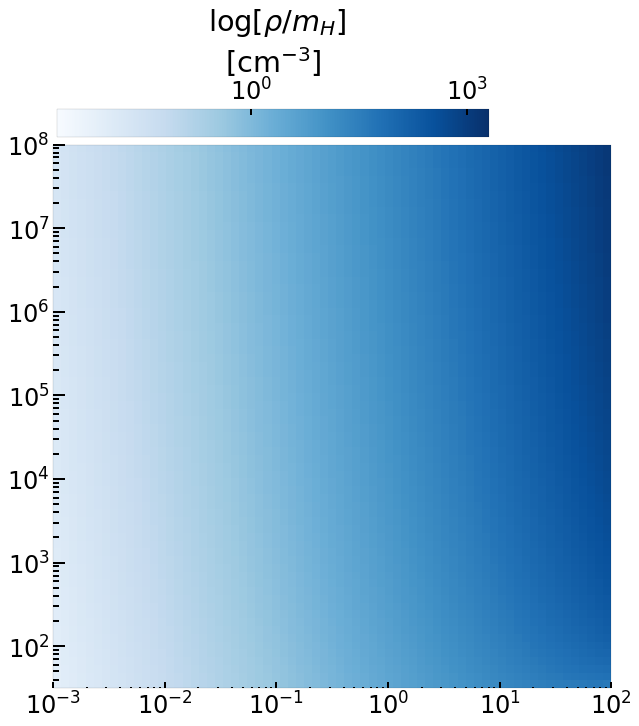

In [144]:
fig, ax = plt.subplots(1, 1, gridspec_kw = {'wspace':0.01, 'hspace':0.0},figsize=(10, 10))
i=0


plot = ax.pcolormesh(rho_arr, temp_arr, np.transpose(ent_arr),\
                norm=mcolors.LogNorm(vmin=2.e-3, vmax=2.e3),
                cmap=sns.color_palette(palette='Blues', as_cmap=True))
cax = fig.add_axes([cbarx, cbary, 4.*cblen, 4.*cbheight])
fig.colorbar(plot, cax=cax, orientation='horizontal', ticks=(1.e-3, 1., 1.e3))
cax.xaxis.set_ticks_position('top')
cax.set_title(r" $\mathrm{log} [\rho/m_H]$" + "\n" + "[cm$^{-3}$]")
ax.set_yscale('log')
ax.set_xscale('log')
# ax[0].text(0.4, 0.9, '%.2f'%(timestep) + ' Myr', transform = ax[0].transAxes, color='black')

# Slice for 0.2Sigma

/jobfs/126640808.gadi-pbs/ipykernel_2432450/3134100736.py:54: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plot = ax[0].pcolormesh(xrange/kpc,zrange/kpc, np.transpose(np.log10(rho_gas/mp)),\
/jobfs/126640808.gadi-pbs/ipykernel_2432450/3134100736.py:63: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plot = ax[1].pcolormesh(xrange/kpc,zrange/kpc, np.transpose((temp)),\
/jobfs/126640808.gadi-pbs/ipykernel_2432450/3134100736.py:71: MatplotlibDeprecationWarning: 

Created file-- /g/data/jh2/av5889/quokka_myrepo/Analysis/figures/Paper/sigma0.2fid_slice_full.jpeg


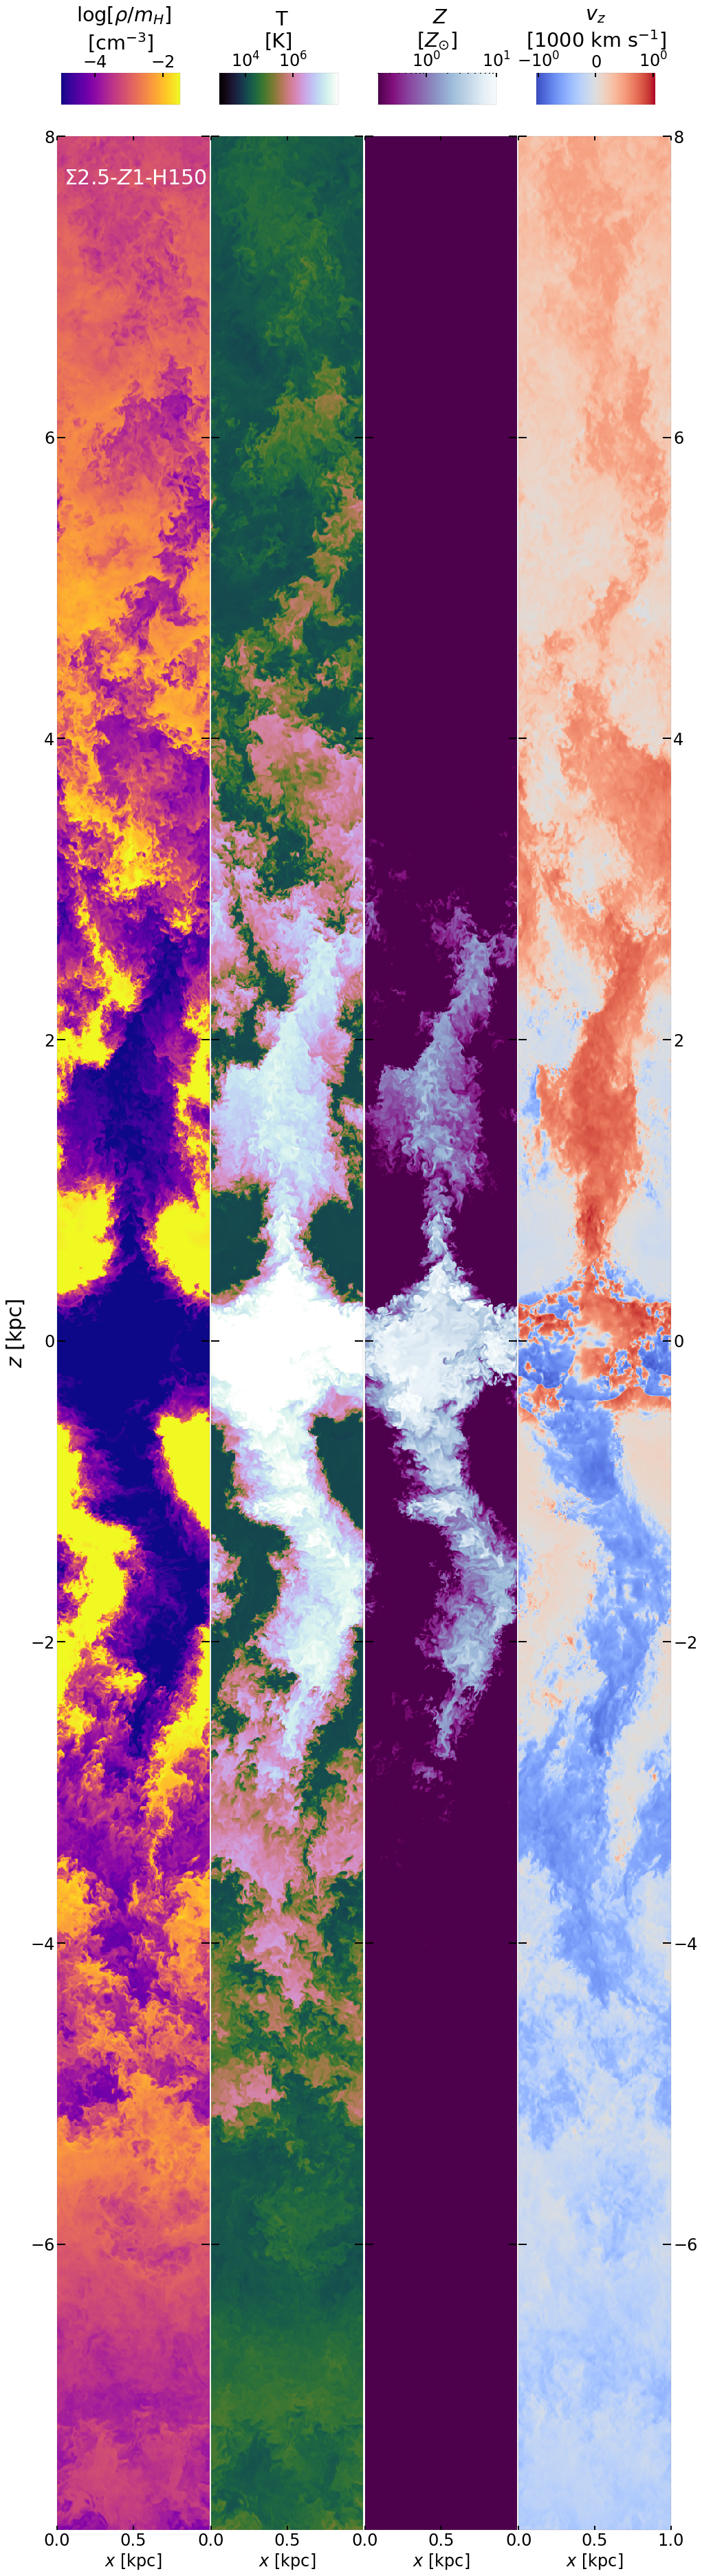

In [78]:
fig, ax = plt.subplots(1, 4, gridspec_kw = {'wspace':0.01, 'hspace':0.0},figsize=(16, 64))
i=0

cbarx = 0.13
cbheight = 0.01
cbary = 0.89
cblen = 0.15
dx1 = 0.2
cbtitlex = 0.1
cbtitley = 16.5

kk=0

home = '/scratch/jh2/av5889/sims/SetonixRuns/'

folder = data_folder[2]

data_path = os.path.join(home, folder)
hf = h5py.File(data_path ,'r')

eint = np.array(hf.get("IntEnergy"))
timestep = np.array(hf.get("Timestep")) 
zrange = np.array(hf.get("Zrange"))
xrange = np.array(hf.get("Xrange"))
rho_gas = np.array(hf.get("Rho")) 
rhoZ = np.array(hf.get("RhoZ")) 
vz = np.array(hf.get("Vz")) 
abund = (rhoZ/rho_gas)*Msun/1.e3


cloudy_H_mass_fraction = 1. / (1. + 0.1 * 3.971)
rho0 = rho_gas*cloudy_H_mass_fraction/hydrogen_mass_cgs

logrho_arr = np.log10(nH_arr[:-1])
logrho     = np.log10(rho0)
delta_rho  = logrho_arr[1] - logrho_arr[0]
idxrho     = (np.floor((logrho - np.amin(logrho_arr))/delta_rho)).astype('int')

logEgas_arr = np.log10(egas_arr[:-1])
logEgas     = np.log10(eint)
delta_egas  = logEgas_arr[1] - logEgas_arr[0]
idxegas     = (np.floor((logEgas-np.amin(logEgas_arr))/delta_egas)).astype('int')


wgt_rho  = (logrho - (np.amin(logrho_arr) + delta_rho*idxrho))/delta_rho
wgt_egas = (logEgas - (np.amin(logEgas_arr) + delta_egas*idxegas))/delta_egas

temp = (1.-wgt_rho)*(1.-wgt_egas)* T[tuple(idxegas)  , tuple(idxrho)]   +\
        wgt_rho *    wgt_egas * T[tuple(idxegas+1), tuple(idxrho+1)] +\
    (1. -wgt_rho)*    wgt_egas * T[tuple(idxegas+1), tuple(idxrho)]   +\
        wgt_rho *(1.-wgt_egas)* T[tuple(idxegas)  , tuple(idxrho+1)]  


plot = ax[0].pcolormesh(xrange/kpc,zrange/kpc, np.transpose(np.log10(rho_gas/mp)),\
                vmin=-5., vmax=-1.5,
                cmap=sns.color_palette(palette='plasma', as_cmap=True))
cax = fig.add_axes([cbarx, cbary, cblen, cbheight])
fig.colorbar(plot, cax=cax, orientation='horizontal', ticks=(-6, -4, -2.))
cax.xaxis.set_ticks_position('top')
cax.set_title(r" $\mathrm{log} [\rho/m_H]$" + "\n" + "[cm$^{-3}$]")
# ax[0].text(0.4, 0.9, '%.2f'%(timestep) + ' Myr', transform = ax[0].transAxes, color='black')

plot = ax[1].pcolormesh(xrange/kpc,zrange/kpc, np.transpose((temp)),\
                norm=mcolors.LogNorm(vmin=8.e2, vmax=8.e7),
                cmap='cubehelix')
cax = fig.add_axes([cbarx + dx1, cbary, cblen, cbheight])
fig.colorbar(plot, cax=cax, orientation='horizontal', ticks=(1.e4, 1.e6, 1.e8))
cax.xaxis.set_ticks_position('top')
cax.set_title(r" T" + "\n" + "[K]")

plot = ax[2].pcolormesh(xrange/kpc,zrange/kpc, np.transpose(abund)/8.6e-3,\
                norm=mcolors.LogNorm(vmin=2.e-1, vmax=10.2),
                cmap=sns.color_palette("BuPu_r", as_cmap=True))
cax = fig.add_axes([cbarx + 2.*dx1, cbary, cblen, cbheight])
fig.colorbar(plot, cax=cax, orientation='horizontal', ticks=(1.e-1, 1., 1.e1))
cax.xaxis.set_ticks_position('top')
cax.set_title(r" $Z$ " + "\n" + r"$[Z_{\odot}]$")

plot = ax[3].pcolormesh(xrange/kpc,zrange/kpc, np.transpose(vz)/kmps/1.e3,\
                norm=mcolors.SymLogNorm(vmin=-1.2, vmax=1.2, linthresh=0.05),
                cmap='coolwarm')
cax = fig.add_axes([cbarx + 3.*dx1, cbary, cblen, cbheight])
fig.colorbar(plot, cax=cax, orientation='horizontal', ticks=(-1., 0.0, 1.))
cax.xaxis.set_ticks_position('top')
cax.set_title(r"$v_z$" + "\n" + r"$[1000$ km s$^{-1}]$")



ax[0].tick_params(axis='y', labelleft=True, labelright=False, right=True, left=True)
ax[1].tick_params(axis='y', labelleft=False, labelright=False, right=True, left=True)
ax[2].tick_params(axis='y', labelleft=False, labelright=False, right=True, left=True)
ax[ -1].tick_params(axis='y', labelleft=False, labelright=True, right=True, left=True)
ax[0].tick_params(axis='x', labelbottom=True, top=True, bottom=True)
ax[1].tick_params(axis='x', labelbottom=True, top=True, bottom=True)
ax[2].tick_params(axis='x', labelbottom=True, top=True, bottom=True)
ax[3].tick_params(axis='x', labelbottom=True, top=True, bottom=True)   
ax[0].text(0.045, 0.98, r'$\Sigma2.5$-$Z1$-H$150$', transform=ax[0].transAxes, color='white', fontsize=30)

plt.setp(ax, 'ylim', (-7.9,8.))
plt.setp(ax, 'xlim', (0.0,1.0))

plt.setp(ax, 'yticks', (-6., -4., -2., 0.0, 2.0, 4.0, 6.0, 8.0))
ax[-1].set_xticks((0.0, 0.5, 1.0))

ax[0].set_ylabel(r'$z$ [kpc]', fontsize=30)
kk+=1
plt.setp(ax, 'xlabel', r'$x$ [kpc]')
plt.setp(ax, 'xticks', (0.0,0.5))
plt.setp(ax[-1], 'xticks', (0.0,0.5, 1.0))

filename = fig_path + '/Paper/sigma0.2fid_slice_full.jpeg'
plt.savefig(filename, bbox_inches='tight', dpi=160)
print('Created file--', filename)
entropy_volR16 = rho_gas * np.log(rho_gas**(1.-gamma)*temp)